## Progetto AI
analisi del Dataset fornito
# Introduzione
importazione delle librerie necessarie

In [ ]:
!pip install kneed


import pandas as pd
import chardet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap


from google.colab import drive

#monto il drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Inizializzo il path del dataset
path = '/content/drive/MyDrive/Dataset/apartments_for_rent_classified_10K.csv'

#leggo il file
df = pd.read_csv(path, encoding="windows-1252",sep=";")

#stampa del dataset
display(df.shape)
display(df)


(10000, 22)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5630240092,housing/rent/apartment,Five BR 5407 Abbott Place - Abbott,This unit is located at 5407 Abbott Place - Ab...,NaN,4.0,5.0,USD,No,Thumbnail,...,"$6,000",Monthly,6300,5407 Abbott Place Abbott,Edina,MN,44.9000,-93.3233,RentLingo,1575112975
9996,5668640983,housing/rent/apartment,Six BR 256 Las Entradas,"This unit is located at 256 Las Entradas, Mont...",NaN,8.0,6.0,USD,No,Thumbnail,...,"$25,000",Monthly,8716,256 Las Entradas,Montecito,CA,34.4331,-119.6331,RentLingo,1577360419
9997,5668643292,housing/rent/apartment,Six BR 9908 Bentcross Drive,"This unit is located at 9908 Bentcross Drive, ...",NaN,8.5,6.0,USD,No,Thumbnail,...,"$11,000",Monthly,11318,9908 Bentcross Dr,Potomac,MD,39.0287,-77.2409,RentLingo,1577360560
9998,5668662559,housing/rent/apartment,One BR in New York NY 10069,"Monthly Rent$4,605 -to $4,790AmenitiesThe Aldy...","Basketball,Cable or Satellite,Doorman,Hot Tub,...",NaN,1.0,USD,No,Thumbnail,...,"$4,790",Monthly,40000,NaN,New York,NY,40.7716,-73.9876,Listanza,1577362186


##Normalizzazione dei dati
Vado a normalizzare, andando a selezionare solo le colonne utili per il clustering

In [ ]:
#Selezione delle colonne e drop dei valori nAnd
cols_to_use = ["price", "square_feet", "bedrooms", "bathrooms"]
df_selected = df[cols_to_use].dropna()

#Applucazione di uno scaler per normalizzare i dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_selected)
display(X_scaled.shape)
display(X_scaled)



(9960, 4)

array([[-0.09015304, -1.58787725, -1.85599477, -0.6182263 ],
       [-0.52192597, -1.57078118, -1.85599477, -0.6182263 ],
       [ 0.91731713, -1.54418728, -1.85599477, -0.6182263 ],
       ...,
       [21.83276925, 14.76546771,  4.51838728, 10.76053224],
       [ 8.83315417, 19.70813278,  4.51838728, 11.5733007 ],
       [-0.44392828, -0.11951441, -0.79359777, -0.6182263 ]])

##Metodo del gomito
vado ad utilizzare il metodo del gomito per trovare il numero di cluster migliore

In [ ]:
#Definizione funzione generale per il metodo del gomito

def elbow_method(X, start = 2, end = 10):

  #Setto i parametri
  kmeans_params = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300,
    'random_state': 42
  }

  k_values = range(start, end)

  inertias = []
  for k in k_values:
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

  #Stampa il grafico
  plt.plot(k_values, inertias, '-o')
  plt.xlabel('Numero di cluster')
  plt.ylabel('Inertia')
  plt.title('Elbow Method')
  plt.grid()
  plt.show()

  # Trova il punto di gomito
  knee_locator = KneeLocator(k_values, inertias, curve='convex', direction='decreasing')
  elbow_point = knee_locator.elbow
  return elbow_point

##Utilizzo del metodo del gomito
Utilizzo il metodo del gomito, mostrando i risultati

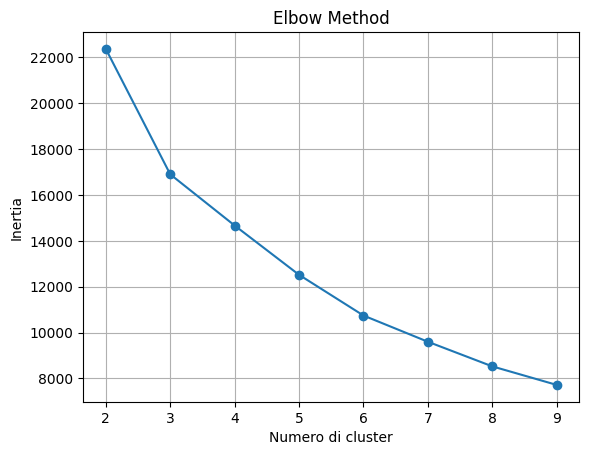

5

In [ ]:
elbow_method(X_scaled)

##Metodo della curvatura
Definisco il metodo della curvatura per stabilire l'ottimo del metodo del gomito

In [ ]:

def elbow_method_knee(X, start=2, end=10):

    # Range dei valori di K
    K_range = list(range(start, end))
    sse = []

    # Calcoliamo l'SSE per ogni valore di K
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)

    # Trova il punto di gomito con KneeLocator
    knee_locator = KneeLocator(K_range, sse, curve="convex", direction="decreasing")
    optimal_k = knee_locator.knee  # Numero ottimale di cluster

    print(f"Numero ottimale di cluster: {optimal_k}")

    # Plottiamo il metodo del gomito
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, sse, marker='o', linestyle='-')
    plt.xlabel("Numero di Cluster (K)")
    plt.ylabel("SSE (Sum of Squared Errors)")
    plt.title("Metodo del Gomito per K-Means")

    if optimal_k is not None:
        plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
        plt.legend()

    plt.grid(True)
    plt.show()

    return optimal_k



##Utilizzo del metodo della curvatura

Numero ottimale di cluster: 5


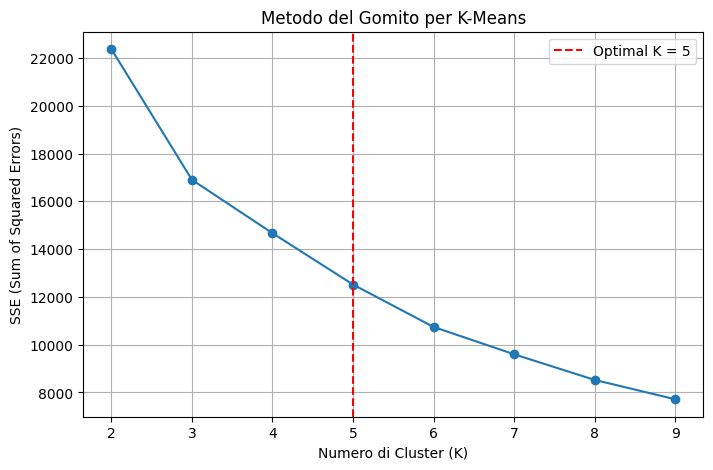

In [ ]:
optimal_k = elbow_method_knee(X_scaled)

##Definizione del K-Means
Definisco una funzione per l'utilizzo del K-means, una volta aver ottenuto il numero k di cluster ottimali

In [ ]:

def apply_kmeans_and_plot(X, df_original, optimal_k, title="Clustering con PCA"):

    # Applicare K-Means
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
    df_clustered = df_original.copy()
    df_clustered["Cluster"] = kmeans.fit_predict(X)

    # Mostrare il numero di punti per cluster
    print(df_clustered["Cluster"].value_counts())

    # Ridurre la dimensionalità a 2 componenti con PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Calcolo degli autovalori e autovettori
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_

    # Ordinare gli autovalori in ordine decrescente e riordinare gli autovettori di conseguenza
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = eigenvectors[sorted_indices]

    centroids_pca = pca.transform(kmeans.cluster_centers_)



    # Stampare gli autovalori e gli autovettori ordinati
    print("Autovalori ordinati (decrescente):", eigenvalues_sorted)

     # Step 3: Creare il grafico con i cluster e i centroidi
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clustered["Cluster"], cmap='tab10', alpha=0.6, label="Dati",s=80)

    # Plottiamo i centroidi
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label="Centroidi")

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.legend()
    plt.show()

    return df_clustered



##Sviluppo del clustering utilizzando valore ottimo

Cluster
0    4761
4    2625
2    2055
1     514
3       5
Name: count, dtype: int64
Autovalori ordinati (decrescente): [2.76253132 0.75319195]


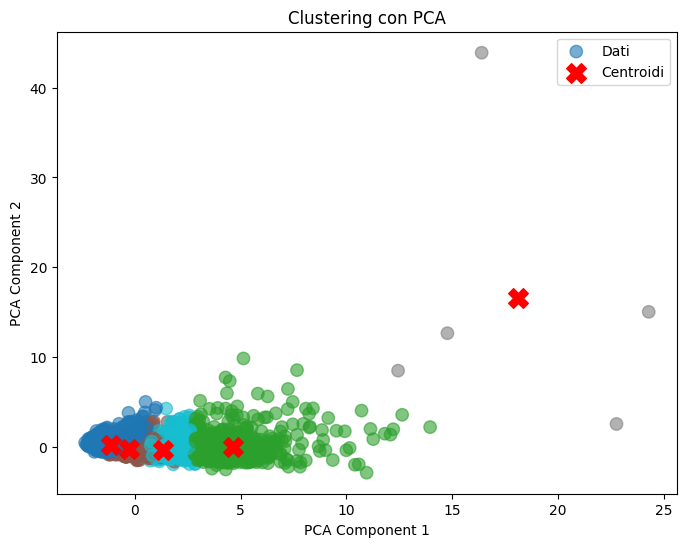

In [ ]:
df_clustered = apply_kmeans_and_plot(X_scaled, df_selected, optimal_k)

#Sviluppo del clustering decrementando k
Diminuisco il valore k per cercare di cambiare i valori prodotti dal clustering

Cluster
1    6482
3    2700
0     706
2      72
Name: count, dtype: int64
Autovalori ordinati (decrescente): [2.76253132 0.75319195]


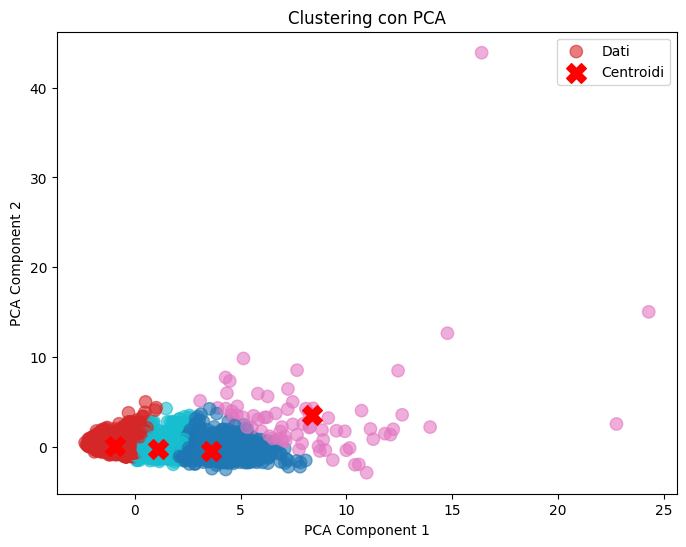

In [ ]:
df_clustered2 = apply_kmeans_and_plot(X_scaled, df_selected, 4)

#Normalizzazione dei dati clustering 2
Vado ad eseguire un secondo clustering andando ad evidenziare questa volta come parametri solamente il prezzo e la grandezza

In [ ]:
df_price_size = df[["price", "square_feet"]].dropna()

scaler = StandardScaler()
X_price_size = scaler.fit_transform(df_price_size)



##Metodo del gomito


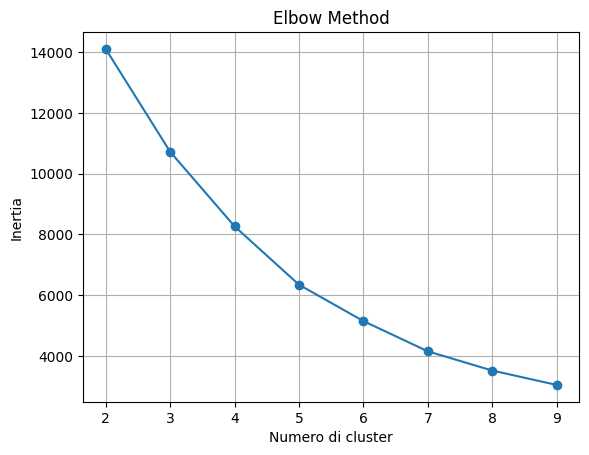

5

In [ ]:
elbow_method(X_price_size)

#Punto di ottimo

Numero ottimale di cluster: 5


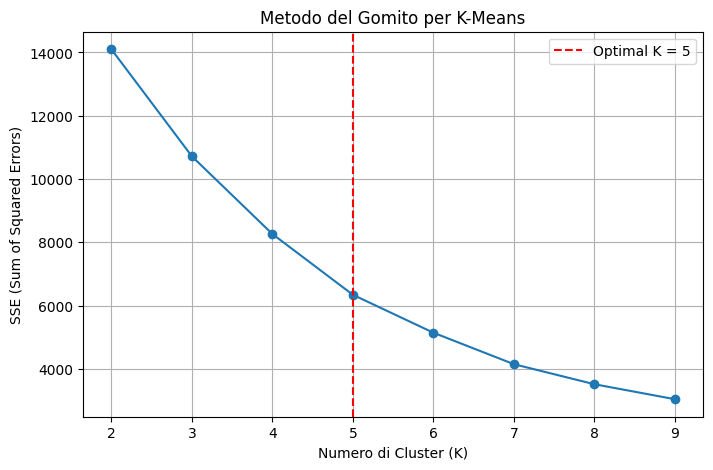

In [ ]:
optimal_k_2 = elbow_method_knee(X_price_size,2,10)

#K-Means senza PCA

In [ ]:
def apply_kmeans_and_plot_without_pca(X, df_original, optimal_k, pr1, pr2, title="Clustering senza PCA"):
    # Applicare K-Means
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
    df_clustered = df_original.copy()
    df_clustered["Cluster"] = kmeans.fit_predict(X)

    # Mostrare il numero di punti per cluster
    print(df_clustered["Cluster"].value_counts())

    # Ottenere i centroidi
    centroids = kmeans.cluster_centers_

    # Creare il grafico con i cluster e i centroidi
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=df_clustered["Cluster"], cmap='viridis', alpha=0.6, label="Dati")

    # Plottiamo i centroidi
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label="Centroidi")

    plt.xlabel(pr1)
    plt.ylabel(pr2)
    plt.title(title)
    plt.legend()
    plt.show()

    return df_clustered


#Sviluppo del clustering con valore ottimo

Cluster
1    6876
0    2811
2     309
4       3
3       1
Name: count, dtype: int64


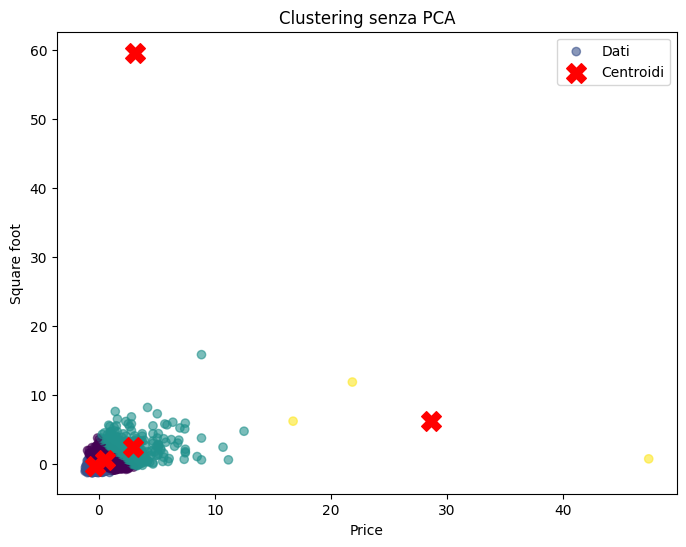

In [ ]:
df_clustered_3 = apply_kmeans_and_plot_without_pca(X_price_size, df_price_size, optimal_k_2, "Price", "Square foot", title="Clustering senza PCA")

#Plot prezzo i size su latitudine e longitudine

Cluster
1    6876
0    2811
2     309
4       3
3       1
Name: count, dtype: int64


<ipython-input-58-08d0b890a6b5>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


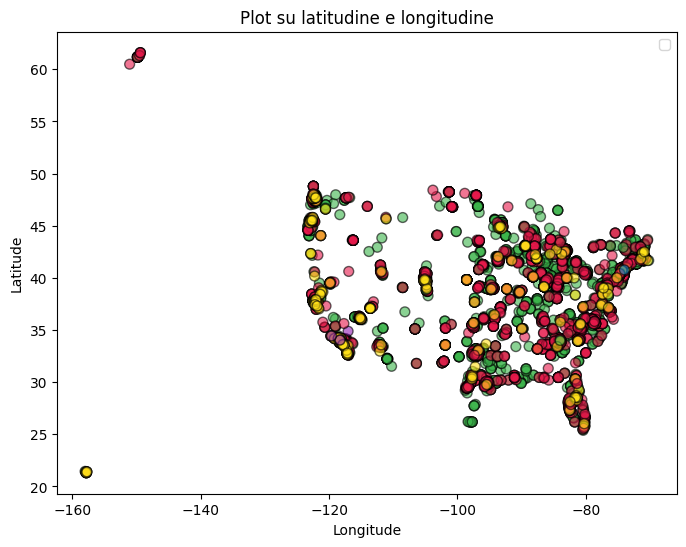

In [ ]:
# Definiamo la palette intensa
palette_intensa = [
    "#E6194B",  # Rosso brillante
    "#3CB44B",  # Verde intenso
    "#FFE119",  # Giallo acceso
    "#0082C8",  # Blu brillante
    "#911EB4",  # Viola intenso
]

# Creiamo una colormap personalizzata
cmap_personalizzata = ListedColormap(palette_intensa)

# Applicare K-Means
kmeans = KMeans(n_clusters=optimal_k_2, random_state=42, n_init=10, max_iter=300)
df_clustered = df_price_size.copy()
df_clustered["Cluster"] = kmeans.fit_predict(X_price_size)

# Mostrare il numero di punti per cluster
print(df_clustered["Cluster"].value_counts())

# Creare il grafico con i cluster e i centroidi
plt.figure(figsize=(8, 6))
plt.scatter(df["longitude"], df["latitude"], c=df_clustered["Cluster"], cmap = cmap_personalizzata, alpha=0.6, edgecolors='k', s=50)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Plot su latitudine e longitudine")
plt.legend()
plt.show()

##Clustering 3
normalizzazione dei dati

In [ ]:
df_location = df[["longitude", "latitude"]].dropna()

scaler = StandardScaler()
X_location = scaler.fit_transform(df_location)

#Metodo del gomito

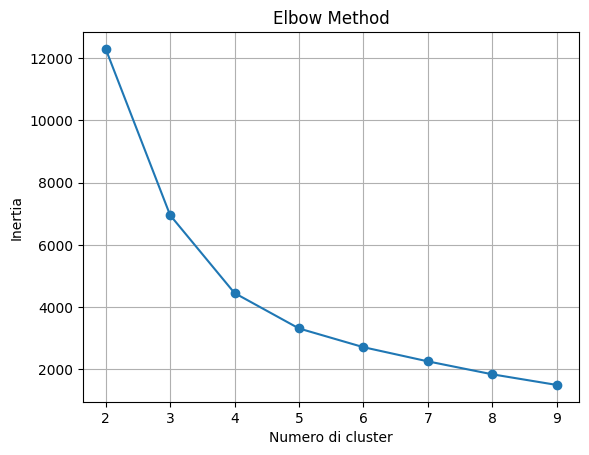

4

In [ ]:
elbow_method(X_location)

#Punto di ottimo

Numero ottimale di cluster: 4


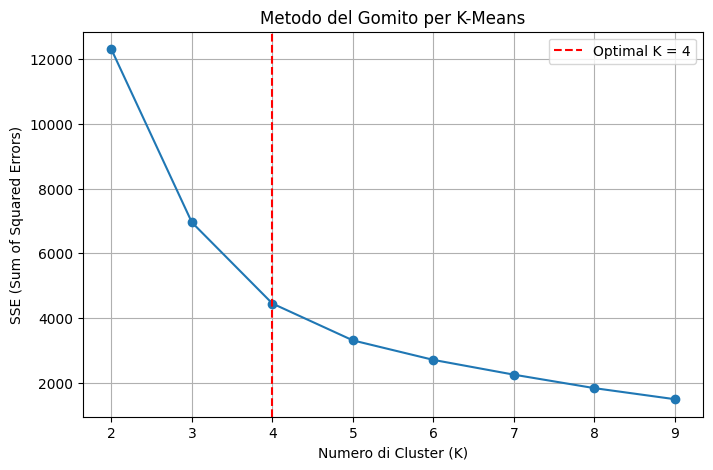

In [ ]:
optimal_k_3 = elbow_method_knee(X_location)

#K-Means

Cluster
0    4540
2    2913
1    1642
3     895
Name: count, dtype: int64


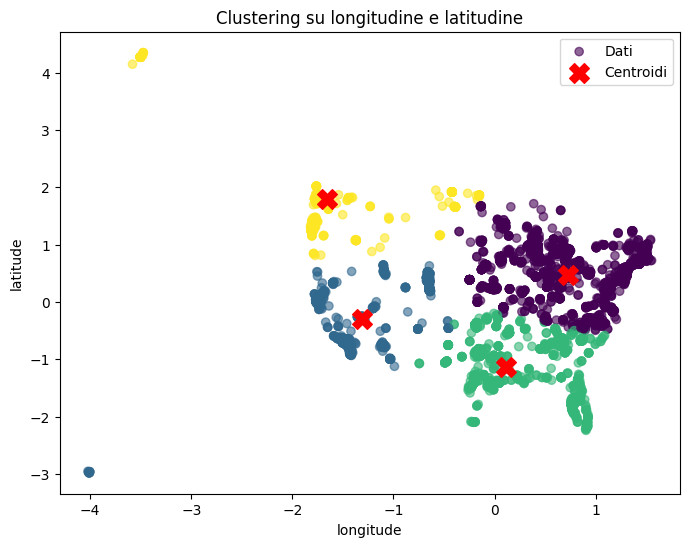

In [ ]:
df_clustered_4 = apply_kmeans_and_plot_without_pca(X_location, df_location, optimal_k_3 , "longitude", "latitude", "Clustering su longitudine e latitudine")